# Anomaly Detection using pyod

# Load libraries

In [1]:
import os
import datetime

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras import backend as K

# mpl.rcParams['figure.figsize'] = (8, 6)
# mpl.rcParams['axes.grid'] = False

from sklearn.model_selection import LeaveOneGroupOut

# Load configuration

In [2]:
# Garmin features
features = ['heart_rate', 'steps', 'stress_score',
           'awake', 'deep', 'light', 'rem', 
           'nonrem_total', 'total', 'nonrem_percentage', 'sleep_efficiency']

# Additional features
#   'timestamp_hour'
features += ['timestamp_dayofweek', 'timestamp_hour_sin', 'timestamp_hour_cos']

TARGET_COLUMN = 'wearing_off'
features.append(TARGET_COLUMN)

columns = ['timestamp'] + features + ['participant']

In [22]:
from IPython.core.display import display, HTML

def display_side_by_side(dfs:list, captions:list, tablespacing=5):
  """Display tables side by side to save vertical space
  Input:
      dfs: list of pandas.DataFrame
      captions: list of table captions
  """
  output = ""
  for (caption, df) in zip(captions, dfs):
      output += df.style.set_table_attributes("style='display:inline'").set_caption(caption)._repr_html_()
      output += tablespacing * "\xa0"
  display(HTML(output))

# Load dataset

In [3]:
df = pd.read_excel('../../data/4-combined_data.xlsx',
                  index_col="timestamp",
                  usecols=columns,
                  sheet_name="combined",
                  engine='openpyxl')

# Fill missing data with 0
df.fillna(0, inplace=True)

# Split dataset

In [4]:
PARTICIPANT_AS_TEST = 13

column_indices = {name: i for i, name in enumerate(df.columns)}
# Select all except specified participant (used for training)
general_df = df.query(f'participant != {PARTICIPANT_AS_TEST}')[features].copy()
train_df = general_df[0:int( len(general_df) * 0.6 )]
val_df = general_df[int( len(general_df) * 0.6 ):]

test_participant_df = df.query(f'participant == {PARTICIPANT_AS_TEST}')[features].copy()
fine_tuning_df = test_participant_df[0:int( len(test_participant_df) * 0.5 )]
test_df = test_participant_df[int( len(test_participant_df) * 0.5 ):]

# Normalize dataset

In [5]:
normalize_features = ['heart_rate', 'steps', 'stress_score', 'awake', 'deep', 
                      'light', 'rem', 'nonrem_total', 'total', 'nonrem_percentage',
                      'sleep_efficiency', 'timestamp_hour_sin', 'timestamp_hour_cos']
def normalize_data(df, mean, std, normalize_features=normalize_features):
  df_to_normalize = df.copy()
  df_to_normalize.loc[:, normalize_features] = ((
    df_to_normalize.loc[:, normalize_features] - mean
  ) / std)
  
  return df_to_normalize

In [6]:
general_mean = general_df.loc[:, normalize_features].mean()
general_std = general_df.loc[:, normalize_features].std()

train_df = normalize_data(train_df, general_mean, general_std)
val_df = normalize_data(val_df, general_mean, general_std)
fine_tuning_df = normalize_data(fine_tuning_df, general_mean, general_std)
test_df = normalize_data(test_df, general_mean, general_std)

# Anomaly detection

In [304]:
from pyod.models.suod import SUOD
from pyod.models.lof import LOF
from pyod.models.iforest import IForest
from pyod.models.copod import COPOD
from pyod.models.ecod import ECOD
from pyod.models.xgbod import XGBOD
from pyod.utils.utility import standardizer
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize
from sklearn.decomposition import PCA

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

XGBoostError: 
XGBoost Library (libxgboost.so) could not be loaded.
Likely causes:
  * OpenMP runtime is not installed
    - vcomp140.dll or libgomp-1.dll for Windows
    - libomp.dylib for Mac OSX
    - libgomp.so for Linux and other UNIX-like OSes
    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.

  * You are running 32-bit Python on a 64-bit OS

Error message(s): ["/opt/conda/lib/python3.9/site-packages/zmq/backend/cython/../../../../.././libstdc++.so.6: version `GLIBCXX_3.4.30' not found (required by /opt/conda/lib/libxgboost.so)"]


## Sample Data

In [173]:
contamination = 0.1  # percentage of outliers
n_train = 200  # number of training points
n_test = 100  # number of testing points

# Generate sample data
X_train, X_test, y_train, y_test = \
    generate_data(n_train=n_train,
                  n_test=n_test,
                  n_features=14,
                  contamination=contamination,
                  random_state=42)

### IForest

In [174]:
# train IForest detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X_train)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [175]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# example of the feature importance
feature_importance = clf.feature_importances_
print("Feature importance", feature_importance)


On Training Data:
IForest ROC:1.0, precision @ rank n:1.0

On Test Data:
IForest ROC:1.0, precision @ rank n:1.0
Feature importance [0.06268869 0.06700352 0.06020214 0.0816868  0.06163246 0.08129005
 0.07431683 0.06570121 0.07621109 0.08686379 0.06358805 0.06752749
 0.07481482 0.07647306]


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        90
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



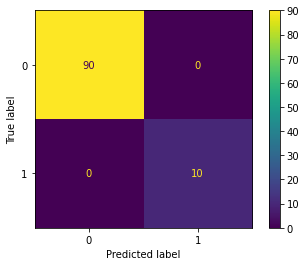

In [97]:
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

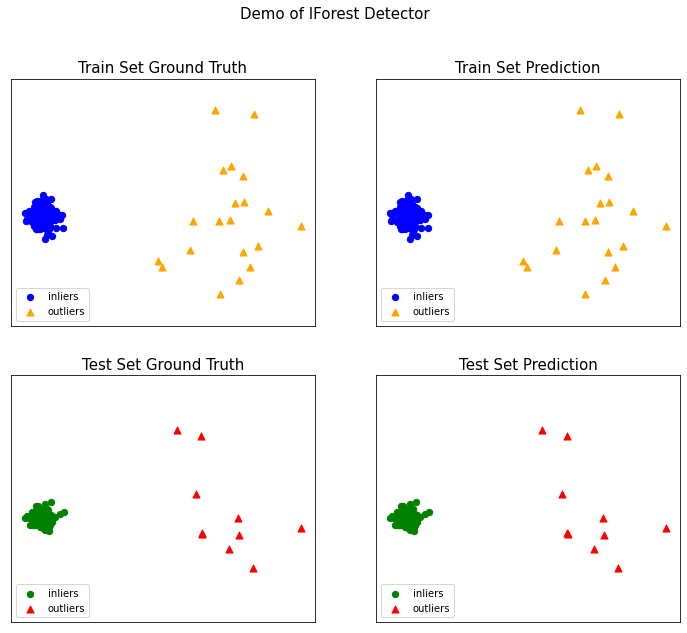

In [85]:
X_train_reduced = PCA(n_components=2, random_state=4).fit_transform(X_train)
X_test_reduced = PCA(n_components=2, random_state=4).fit_transform(X_test)

# visualize the results
visualize(clf_name, X_train_reduced, y_train, X_test_reduced, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

### SUOD Framework

In [93]:
# train SUOD framework
clf_name = 'SUOD'

# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
                  LOF(n_neighbors=25), LOF(n_neighbors=35),
                  COPOD(), IForest(n_estimators=100),
                  IForest(n_estimators=200)]

# decide the number of parallel process, and the combination method
clf = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
            verbose=False)

clf.fit(X_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.1s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.6s finished


SUOD(approx_clf=None, approx_clf_list=None, approx_flag_global=True,
   approx_ng_clf_list=None,
   base_estimators=[LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=15, novelty=True, p=2), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2...features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=None,
    verbose=0)],
   bps_flag=True, combination='average', contamination=0.1,
   cost_forecast_loc_fit=None, cost_forecast_loc_pred=None,
   jl_method='basic', n_jobs=2, rp_clf_list=None, rp_flag_global=True,
   rp_ng_clf_list=None, target_dim_frac=0.5, verbose=False)

In [94]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.7s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.7s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.




On Training Data:
SUOD ROC:1.0, precision @ rank n:1.0

On Test Data:
SUOD ROC:1.0, precision @ rank n:1.0


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.4s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    1.4s finished


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        90
         1.0       1.00      1.00      1.00        10

    accuracy                           1.00       100
   macro avg       1.00      1.00      1.00       100
weighted avg       1.00      1.00      1.00       100



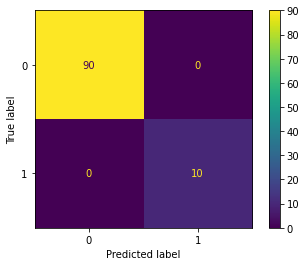

In [96]:
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

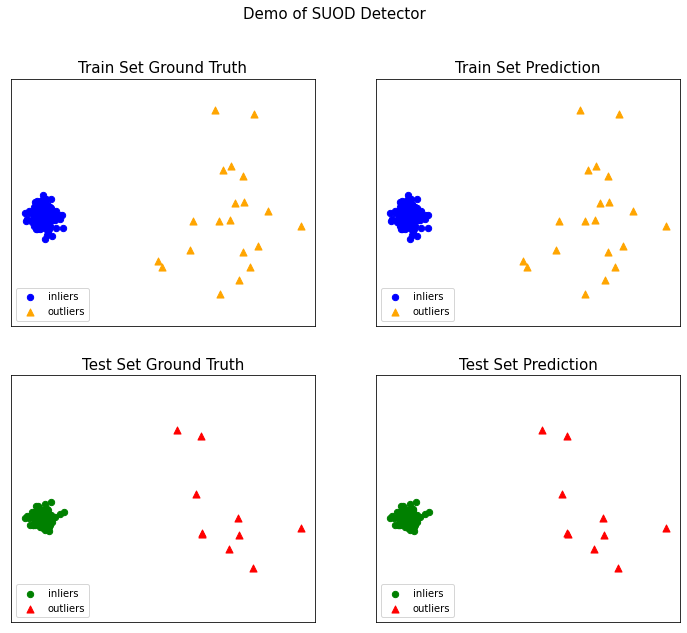

In [98]:
X_train_reduced = PCA(n_components=2, random_state=4).fit_transform(X_train)
X_test_reduced = PCA(n_components=2, random_state=4).fit_transform(X_test)

# visualize the results
visualize(clf_name, X_train_reduced, y_train, X_test_reduced, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

### Semi-Supervised

In [136]:
# Define the number of labeled examples to use
n_labeled = 50

# Combine the labeled and unlabeled examples i.e., unlabeled is the X_test shape with -1 values
X = np.concatenate([X_train[:n_labeled], X_test])
y = np.concatenate([y_train[:n_labeled], np.full(X_test.shape[0], -1)])

In [138]:
# train IForest detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X, y)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [184]:
# Predict the test set labels
y_test_pred = clf.predict(X_test)

# Compute the accuracy of the predictions
acc = np.mean(y_test_pred == y_test)
print(f"Accuracy: {acc:.2f}")

Accuracy: 1.00


In [185]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
# print("\nOn Training Data:")
# evaluate_print(clf_name, y, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# example of the feature importance
feature_importance = clf.feature_importances_
print("Feature importance", feature_importance)


On Test Data:
IForest ROC:1.0, precision @ rank n:1.0
Feature importance [0.06268869 0.06700352 0.06020214 0.0816868  0.06163246 0.08129005
 0.07431683 0.06570121 0.07621109 0.08686379 0.06358805 0.06752749
 0.07481482 0.07647306]


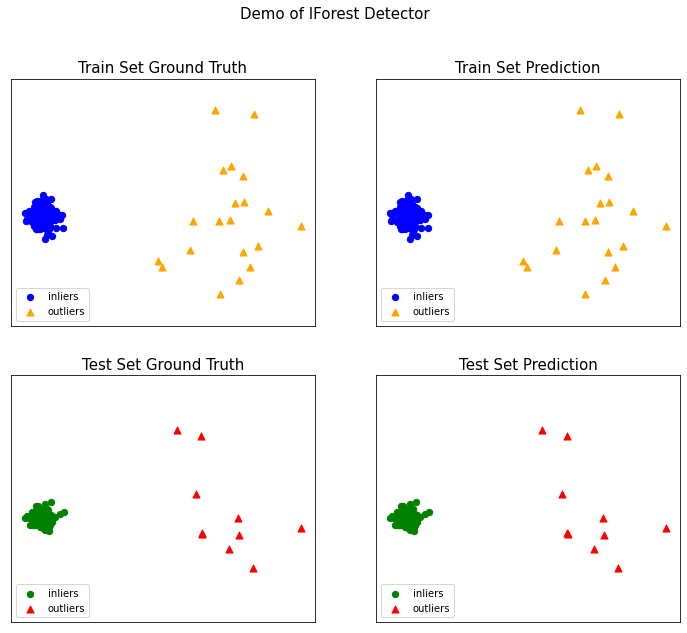

In [186]:
X_train_reduced = PCA(n_components=2, random_state=4).fit_transform(X_train)
X_test_reduced = PCA(n_components=2, random_state=4).fit_transform(X_test)

# visualize the results
visualize(clf_name, X_train_reduced, y_train, X_test_reduced, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

## Wearing-off Data

In [187]:
X_train = train_df.iloc[:, :14]
y_train = train_df.iloc[:, -1:]

X_test = test_df.iloc[:, :14]
y_test = test_df.iloc[:, -1:]

### IForest

In [101]:
# train IForest detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X_train)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [102]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# example of the feature importance
feature_importance = clf.feature_importances_
print("Feature importance", feature_importance)


On Training Data:
IForest ROC:0.471, precision @ rank n:0.0955

On Test Data:
IForest ROC:0.4621, precision @ rank n:0.0305
Feature importance [0.11335681 0.08703072 0.10411598 0.04515223 0.04543912 0.04637394
 0.04872672 0.0420469  0.05010333 0.03950719 0.04234129 0.07009918
 0.13178167 0.13392494]


              precision    recall  f1-score   support

           0       0.94      0.95      0.95      2764
           1       0.01      0.01      0.01       164

    accuracy                           0.90      2928
   macro avg       0.47      0.48      0.48      2928
weighted avg       0.89      0.90      0.89      2928



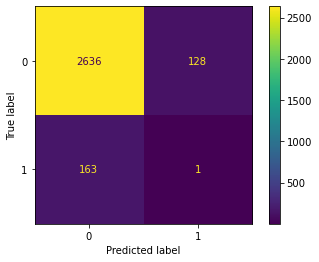

In [103]:
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

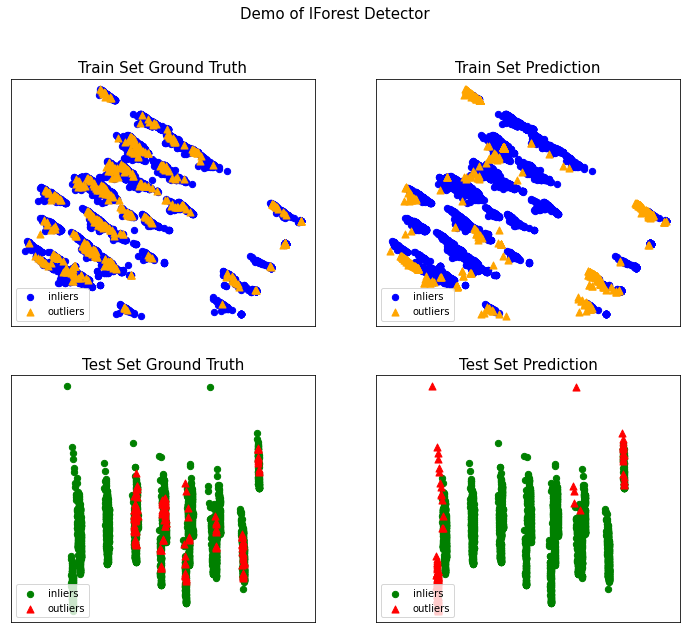

In [104]:
X_train_reduced = PCA(n_components=2, random_state=4).fit_transform(X_train)
X_test_reduced = PCA(n_components=2, random_state=4).fit_transform(X_test)

# visualize the results
visualize(clf_name, X_train_reduced, y_train, X_test_reduced, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

### SUOD Framework

In [105]:
# train SUOD framework
clf_name = 'SUOD'

# initialized a group of outlier detectors for acceleration
detector_list = [LOF(n_neighbors=15), LOF(n_neighbors=20),
                  LOF(n_neighbors=25), LOF(n_neighbors=35),
                  COPOD(), IForest(n_estimators=100),
                  IForest(n_estimators=200)]

# decide the number of parallel process, and the combination method
clf = SUOD(base_estimators=detector_list, n_jobs=2, combination='average',
            verbose=False)

clf.fit(X_train)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    2.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:   11.9s finished


SUOD(approx_clf=None, approx_clf_list=None, approx_flag_global=True,
   approx_ng_clf_list=None,
   base_estimators=[LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=15, novelty=True, p=2), LOF(algorithm='auto', contamination=0.1, leaf_size=30, metric='minkowski',
  metric_params=None, n_jobs=1, n_neighbors=20, novelty=True, p=2...features=1.0,
    max_samples='auto', n_estimators=200, n_jobs=1, random_state=None,
    verbose=0)],
   bps_flag=True, combination='average', contamination=0.1,
   cost_forecast_loc_fit=None, cost_forecast_loc_pred=None,
   jl_method='basic', n_jobs=2, rp_clf_list=None, rp_flag_global=True,
   rp_ng_clf_list=None, target_dim_frac=0.5, verbose=False)

In [106]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
print("\nOn Training Data:")
evaluate_print(clf_name, y_train, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    3.6s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.




On Training Data:
SUOD ROC:0.5011, precision @ rank n:0.092

On Test Data:
SUOD ROC:0.5002, precision @ rank n:0.0305


[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=2)]: Done   2 out of   2 | elapsed:    0.9s finished


              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2764
           1       0.03      0.04      0.03       164

    accuracy                           0.87      2928
   macro avg       0.49      0.48      0.48      2928
weighted avg       0.89      0.87      0.88      2928



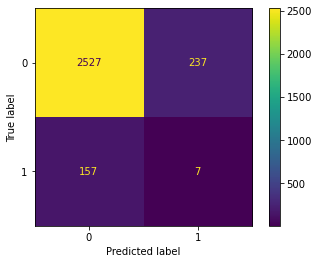

In [107]:
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

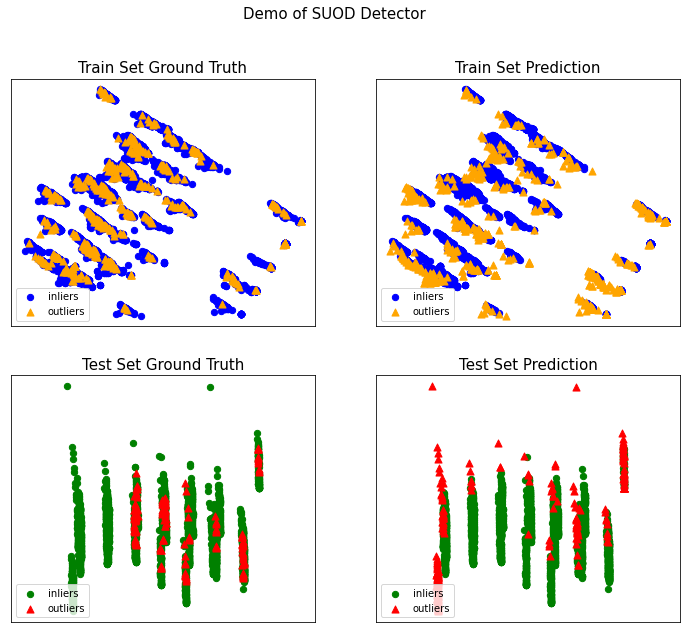

In [108]:
X_train_reduced = PCA(n_components=2, random_state=4).fit_transform(X_train)
X_test_reduced = PCA(n_components=2, random_state=4).fit_transform(X_test)

# visualize the results
visualize(clf_name, X_train_reduced, y_train, X_test_reduced, y_test, y_train_pred,
          y_test_pred, show_figure=True, save_figure=False)

### Semi-supervised

In [254]:
X_train = train_df.iloc[:, :14]
y_train = train_df.iloc[:, -1:]

X_test = test_df.iloc[:, :14]
y_test = test_df.iloc[:, -1:]

In [255]:
# Define the number of labeled examples to use
n_labeled = 50

# Combine the labeled and unlabeled examples
X = np.concatenate([X_train.iloc[:n_labeled], X_test])
y = np.concatenate([y_train.iloc[:n_labeled].values.reshape(n_labeled), np.full(X_test.shape[0], -1)])

In [256]:
# train IForest detector
clf_name = 'IForest'
clf = IForest()
clf.fit(X, y)

IForest(behaviour='old', bootstrap=False, contamination=0.1, max_features=1.0,
    max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
    verbose=0)

In [257]:
# get the prediction labels and outlier scores of the training data
y_train_pred = clf.labels_  # binary labels (0: inliers, 1: outliers)
y_train_scores = clf.decision_scores_  # raw outlier scores

# get the prediction on the test data
y_test_pred = clf.predict(X_test)  # outlier labels (0 or 1)
y_test_scores = clf.decision_function(X_test)  # outlier scores

# evaluate and print the results
# print("\nOn Training Data:")
# evaluate_print(clf_name, y, y_train_scores)
print("\nOn Test Data:")
evaluate_print(clf_name, y_test, y_test_scores)

# example of the feature importance
feature_importance = clf.feature_importances_
print("Feature importance", feature_importance)


On Test Data:
IForest ROC:0.5221, precision @ rank n:0.0732
Feature importance [0.12449956 0.08769387 0.13098789 0.0453571  0.04655215 0.04092014
 0.0347681  0.03979028 0.04160006 0.04070856 0.04413825 0.05063708
 0.13609168 0.13625528]


              precision    recall  f1-score   support

           0       0.94      0.91      0.93      2764
           1       0.05      0.08      0.06       164

    accuracy                           0.87      2928
   macro avg       0.50      0.50      0.50      2928
weighted avg       0.89      0.87      0.88      2928



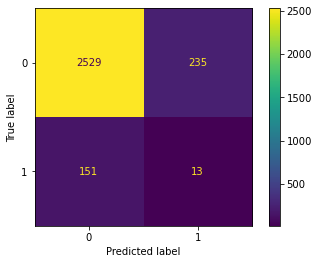

In [258]:
print(classification_report(y_test, y_test_pred))
cm = confusion_matrix(y_test, y_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [271]:
print( len(X_reduced), len(y), len(y_train_pred) )
print( len(X_test_reduced), len(y_test), len(y_test_pred) )

2978 2978 2978
2928 2928 2928


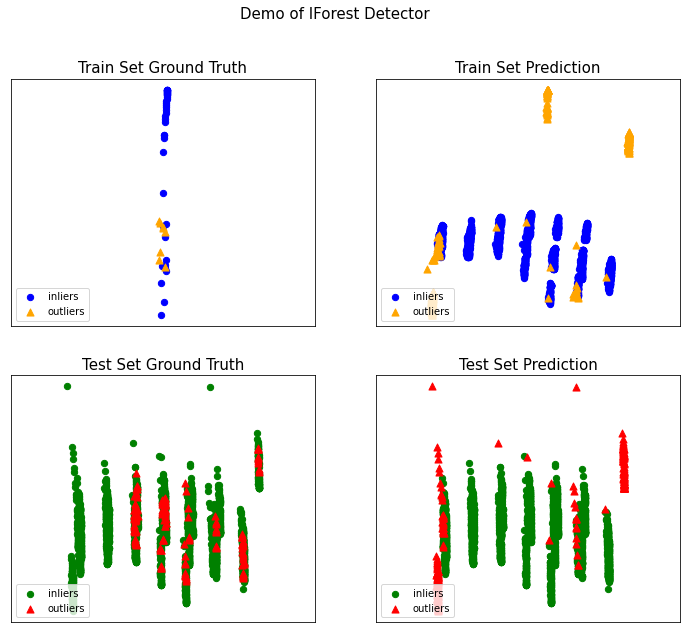

In [297]:
X_train_reduced = PCA(n_components=2, random_state=4).fit_transform(X_train)
X_reduced = PCA(n_components=2, random_state=4).fit_transform(X)
X_test_reduced = PCA(n_components=2, random_state=4).fit_transform(X_test)

# visualize the results
# visualize(clf_name, X_train_reduced, y_train, X_test_reduced, y_test, clf.predict(X_train),
#           y_test_pred, show_figure=True, save_figure=False)
visualize(clf_name, 
          X_train=X_reduced, y_train=y,
          X_test=X_test_reduced, y_test=y_test,
          y_train_pred=y_train_pred, y_test_pred=y_test_pred,
          show_figure=True, save_figure=False)

<AxesSubplot:xlabel='0', ylabel='1'>

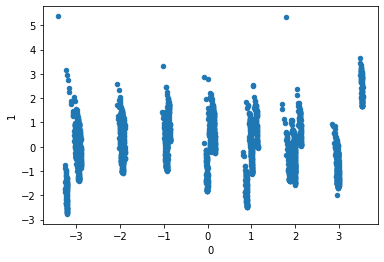

In [292]:
pd.DataFrame(X_test_reduced).plot(kind="scatter", x=0, y=1)